<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.




## Подготовка

In [1]:
#импортируем все необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
RND = 12345

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В наборе данных 26496 наблюдений и 2 столбца.
Наблюдения в датасете сделаны с разницей в 10 минут. Это слишком подробные данные. Выполним ресемплирование с интервалом в 1 час. Данные суммируем.

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [4]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные ресемплированы, расположены в хронологическом порядке.

## Анализ

Изучим данные - в какой промежуток времени велось наблюдение?

In [5]:
print("Начало наблюдения:", df.index.min())
print("Конец наблюдения:", df.index.max())

Начало наблюдения: 2018-03-01 00:00:00
Конец наблюдения: 2018-08-31 23:00:00


Нам предоставлены данные с марта по август (включительно) 2018 года.

<AxesSubplot:xlabel='datetime'>

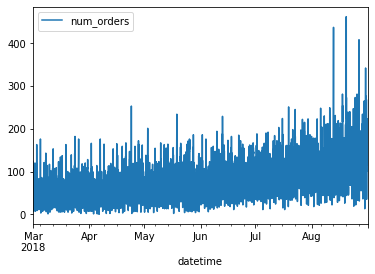

In [6]:
df.plot()

Мы не сможем изучить сезонность по предоставленным данным, так как информация есть только по срезу в полгода. Но можем оценить, как меняется объем заказов от первого наблюдения к последнему. Для наглядности ресемплируем данные по неделе и сохраним в новую переменную. Выведем на график.

<AxesSubplot:xlabel='datetime'>

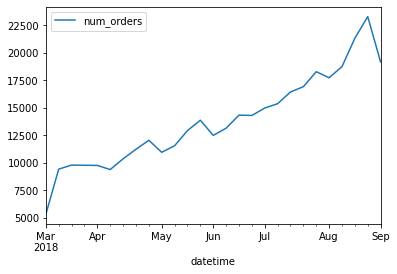

In [7]:
df_week = df.resample('1W').sum()
df_week.plot()

По графику можно сказать - заказы увеличиваются от месяца к месяцу. 
С помощью функции seasonal_decompose() разложим временной ряд на три составляющие: тренд, сезонность и остаток (residuals) - это шум, который не объясняется трендом и сезонностью.

In [8]:
decomposed = seasonal_decompose(df['num_orders'], model='additive')

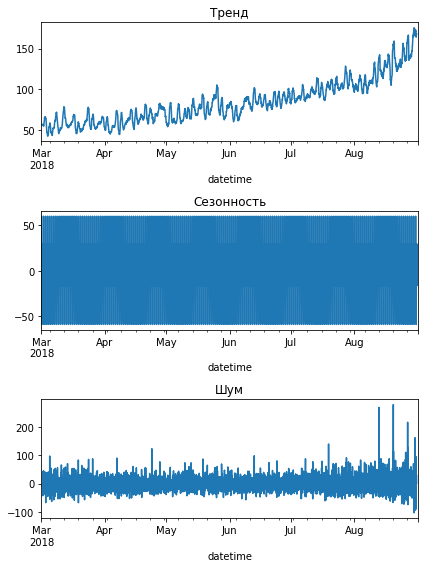

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Здесь также видно, что тренд растет от месяца к месяцу, но чтобы вывести сезонность нагляднее и изучить ее, ресемплируем данные по одному дню.

In [10]:
df_day = df.resample('1D').sum()

In [11]:

decomposed_day = seasonal_decompose(df_day)

Text(0.5, 1.0, 'Сезонность')

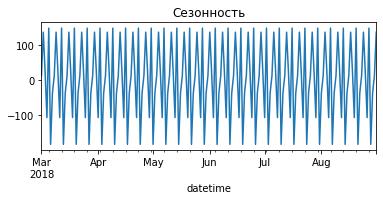

In [12]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Видим колебания раз в неделю.

Найдем разности временного ряда. Станет ли он более стационарным, если применить метод .shift()?


<AxesSubplot:xlabel='datetime'>

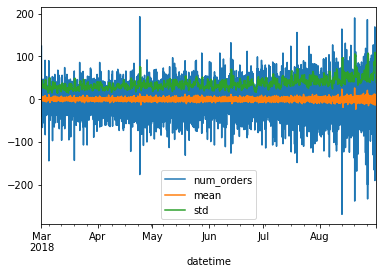

In [13]:
df_shifted = df - df.shift(fill_value=0)
df_shifted['mean'] = df_shifted['num_orders'].rolling(15).mean()
df_shifted['std'] = df_shifted['num_orders'].rolling(15).std()
df_shifted.plot()

Ряд становится более стационарным, а значит данные можно прогнозировать.

## Обучение

Для успешного обучения добавим признаки в датасет. Напишем функцию make_features(), которая:

добавит к датасету четыре новых календарных признака: год, месяц, день и день недели,
вычислит и добавит отстающие значения (предыдущие значения временного ряда, которые покажут, будет ли функция x(t) расти или уменьшаться),
вычислит скользящее среднее и добавит его как признак rolling_mean - этот признак задаст общий тренд временного ряда.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()  

In [15]:
make_features(df, 24, 3)
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


Разделим данные на обучающую и тестовую выборки, а затем поделим признаки.

Функция train_test_split по умолчанию перемешивает данные (что нам в данном случае не нужно), поэтому добавим параметр shuffle=False.

После применения функции make_features у нас появились NaN-значения за счет сдвига данных. Их никак не заполнить - просто избавимся от них.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим, что данные не перемешались - сравним последнее наблюдение признаков обучающей выборки и первое наблюдение признаков тестовой выборки.

In [17]:
print(features_train.index[features_train.shape[0]-1])
print(features_test.index[0])

2018-08-13 13:00:00
2018-08-13 14:00:00


Все верно, данные можно использовать для обучения.

Обучим модели LinearRegression, RandomForestRegressor и LGBMRegressor.

In [18]:
#LinearRegression
#%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predicted_lr = pd.Series(lr_model.predict(features_test))

In [19]:
#Подберем параметры c помощью TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cb_params = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[RND],
                'verbose':[False]}]
            

In [20]:
lr_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [21]:
%%time
lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_params, refit=False,\
                       scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_
lr_m = LinearRegression(**lr_best_params)
lr_m.fit(features_train, target_train)
    
lr_test_pred = lr_m.predict(features_test)

print('Лучшие гиперпараметры: ', lr_best_params)


Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
CPU times: user 1.89 s, sys: 2.85 s, total: 4.75 s
Wall time: 4.77 s


In [22]:
#RandomForestRegressor
rf_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }



In [23]:
%%time
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, refit=False,\
                       scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train)
    
rf_test_pred = rf_m.predict(features_test)

print('Лучшие гиперпараметры: ', rf_best_params)


Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
CPU times: user 3min 11s, sys: 426 ms, total: 3min 12s
Wall time: 3min 12s


In [24]:
#LGBMRegressor
lgb_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }

In [ ]:
%%time
lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, refit=False,\
                        scoring='neg_mean_squared_error', cv=tscv)
lgb_grid.fit(features_train, target_train)

lgb_best_params = lgb_grid.best_params_
lgb_m = LGBMRegressor(**lgb_best_params)
lgb_m.fit(features_train, target_train)
    
lgb_test_pred = lgb_m.predict(features_test)

print('Лучшие гиперпараметры: ', lgb_best_params)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

## Тестирование

In [ ]:
#LinearRegression

print("RMSE тестовой выборки: ", mean_squared_error(target_test, lr_test_pred)**0.5)

In [ ]:
#RandomForestRegressor
print("RMSE тестовой выборки: ", mean_squared_error(target_test, rf_test_pred)**0.5)

In [ ]:
#LGBMRegressor

print("RMSE тестовой выборки: ", mean_squared_error(target_test, lgb_test_pred)**0.5)

In [ ]:
models = [['LR', 23.5 , 45.291], ['RF', 180, 43.755], 
       ['LGB',269,41.82]] 
df = pd.DataFrame(models, columns =['model', 'train_time, sec/msec', 'rmse'])
df

Вывод:Лучший результат показала модель LGBMRegressor со стандартными настройками,хотя время её обучения и составляет наиболее продолжительный срок из представленных моделей. Как прототип сервису такси можно советовать её.